# INFORMATION LEAKAGE

- Data: Generate data
    - y ~ normal (mean = 0, std = 1, n= 100)
    - x ~ normal (mean - 0, std = 1, n = 100, dimension = 10000)
    - y and x uncorrelated each other (no relationship)
- Information Leakage
    - Modeling x and y using ridge + percentile feature selection (f statistics)
    - do feature selection: apply fit and transform to x
    - compute R-square using cross validation
- No information Leakage
    - Modeling x and y using ridge + percentile feature selection (f statistics)
    - Make pipeline: feature selection + regression
    - Compute R-square using cross validation

In [1]:
import pandas as pd
import numpy as np

In [2]:
rnd = np.random.RandomState(seed = 2020)
x = rnd.normal(size = (100, 10000))
y = rnd.normal(size = (100, ))

## Information Leakge

In [3]:
from sklearn.feature_selection import SelectPercentile, f_regression

In [4]:
select = SelectPercentile(score_func=f_regression, percentile=5)
x_selected = select.fit_transform(x,y)
x_selected.shape

(100, 500)

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge

In [6]:
cross_val_score(Ridge(), x_selected, y, cv = 5)

array([0.92165345, 0.89445668, 0.92827414, 0.93088559, 0.91044624])

## No information Leakge

In [7]:
from sklearn.pipeline import Pipeline

In [8]:
select = SelectPercentile(score_func=f_regression, percentile=5)

pipe_ridge = Pipeline([
    ('select', select),
    ('model', Ridge())

])

In [9]:
cross_val_score(pipe_ridge, x, y, cv = 5)

array([-0.0330359 , -0.07840338, -0.06731106, -0.04544685, -0.07314928])

# Algorithm CHains

- Data: Adult.csv
- Target: Income (>50K atau <=50K)
- Preprocess:
    - Missing Value: Simple imputer with constant
    - One Hot Encoding: Relationship, race, sex
    - Binary Encoding: workclass, marital status, occupation, native country
    - Ordianl Encoding: Education (already encoded)
    - No treatment: numerical
    - Out: fnlwgt
- Random State 10, data splitting 70:30
    - Model Tree(Max depth 5, criterion emtropy) and compute F1 using CV
    - Compute another metrics
    - Model logistics Regression (solver liblinear) compute recall +, precision +, f1 +, make ROC and PRC in test set
    - Do hyperparameter tuning for logistic regression (optimize C and solver) optimized by F1 and using stratified CV 5 fold
    - Compare the result (begore and after) in test set

In [10]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report, plot_precision_recall_curve, plot_roc_curve
from sklearn.neighbors import KNeighborsClassifier

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

In [11]:
df = pd.read_csv(r'C:\Users\dheof\Desktop\Help\Purwadhika\Csv_Files\adult.csv')
df

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


## EDA

In [12]:
df.replace('?', np.nan, inplace=True)

In [13]:
df.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64

## Scenario Preprocessing

- Preprocess:
    - Missing Value: Simple imputer with constant
    - One Hot Encoding: Relationship, race, sex
    - Binary Encoding: workclass, marital status, occupation, native country
    - Ordianl Encoding: Education (already encoded)
    - No treatment: numerical
    - Out: fnlwgt

In [14]:
onehot = OneHotEncoder(drop = 'first')
onehotvar = ['relationship', 'race', 'sex']

imputer = SimpleImputer(strategy='constant', fill_value='Others')
binary = ce.BinaryEncoder()

binary_pipeline = Pipeline([
    ('imputer', imputer),
    ('binary encoder', binary)
])

binaryvar = ['workclass', 'marital.status', 'occupation', 'native.country']

transformer = ColumnTransformer([
    ('one hot encoder', onehot, onehotvar),
    ('binary encoder', binary_pipeline, binaryvar)
], remainder='passthrough')

## Data Splitting

In [15]:
x = df.drop(columns = ['income', 'fnlwgt', 'education'])
y = np.where(df['income'] == '>50K', 1, 0)

In [16]:
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    stratify = y, # AGAR PROPORSI SAMA UNTUK TRAIN DAN TEST
    random_state = 10,
    test_size = 0.3
    )

## Modeling Benchmark

In [17]:
skfold = StratifiedKFold(n_splits = 5)

tree = DecisionTreeClassifier(max_depth = 5, criterion = 'entropy', random_state = 10)

estimator = Pipeline([
    ('transformer', transformer),
    ('model', tree)
])

In [18]:
tree_cv_f1 = cross_val_score(estimator, x_train, y_train, scoring = 'f1')
tree_cv_recall = cross_val_score(estimator, x_train, y_train, scoring = 'recall')
tree_cv_precision = cross_val_score(estimator, x_train, y_train, scoring = 'precision')

In [19]:
print('TREE F1')
print('hasil cross validasi', tree_cv_f1)
print('hasil mean cross validasi', tree_cv_f1.mean())
print('hasil cross validasi', tree_cv_f1.std())
print('')
print('TREE Recall')
print('hasil cross validasi', tree_cv_recall)
print('hasil mean cross validasi', tree_cv_recall.mean())
print('hasil cross validasi', tree_cv_recall.std())
print('')
print('TREE Precision')
print('hasil cross validasi', tree_cv_precision)
print('hasil mean cross validasi', tree_cv_precision.mean())
print('hasil cross validasi', tree_cv_precision.std())

TREE F1
hasil cross validasi [0.6226106  0.61480281 0.58849558 0.58738135 0.62121212]
hasil mean cross validasi 0.6069004904458388
hasil cross validasi 0.015708688769425674

TREE Recall
hasil cross validasi [0.51912568 0.51821494 0.48495898 0.47905282 0.52276867]
hasil mean cross validasi 0.5048242183932666
hasil cross validasi 0.018786373305882616

TREE Precision
hasil cross validasi [0.77762619 0.75564409 0.74824191 0.75901876 0.76533333]
hasil mean cross validasi 0.7611728578361665
hasil cross validasi 0.009903924170707266


## Another model and metrics

In [20]:
# def model_evaluation_cv(model, metrics):
#     skfold = StratifiedKFold(n_splits = 5)
#     estimator = Pipeline([
#         ('transformer', transformer),
#         ('model', model)
#     ])

# model_cv = cross_val_score(estimator, x_train, y_train, scoring = metrics)

# print('hasil cross validasi', model_cv)
# print('hasil mean cross validasi', model_cv.mean())
# print('hasil cross validasi', model_cv.std())

In [21]:
logreg = LogisticRegression(solver = 'liblinear')
knn = KNeighborsClassifier(n_neighbors = 5)

In [22]:
# RECALL
logreg_cv_f1 = cross_val_score(estimator, x_train, y_train, scoring = 'f1')
logreg_cv_recall = cross_val_score(estimator, x_train, y_train, scoring = 'recall')
logreg_cv_precision = cross_val_score(estimator, x_train, y_train, scoring = 'precision')

In [23]:
print('Logreg F1')
print('hasil cross validasi', logreg_cv_f1)
print('hasil mean cross validasi', logreg_cv_f1.mean())
print('hasil cross validasi', logreg_cv_f1.std())
print('')
print('Logreg Recall')
print('hasil cross validasi', logreg_cv_recall)
print('hasil mean cross validasi', logreg_cv_recall.mean())
print('hasil cross validasi', logreg_cv_recall.std())
print('')
print('Logreg Precision')
print('hasil cross validasi', logreg_cv_precision)
print('hasil mean cross validasi', logreg_cv_precision.mean())
print('hasil cross validasi', logreg_cv_precision.std())

Logreg F1
hasil cross validasi [0.6226106  0.61480281 0.58849558 0.58738135 0.62121212]
hasil mean cross validasi 0.6069004904458388
hasil cross validasi 0.015708688769425674

Logreg Recall
hasil cross validasi [0.51912568 0.51821494 0.48495898 0.47905282 0.52276867]
hasil mean cross validasi 0.5048242183932666
hasil cross validasi 0.018786373305882616

Logreg Precision
hasil cross validasi [0.77762619 0.75564409 0.74824191 0.75901876 0.76533333]
hasil mean cross validasi 0.7611728578361665
hasil cross validasi 0.009903924170707266


In [24]:
# KNN
knn_cv_f1 = cross_val_score(estimator, x_train, y_train, scoring = 'f1')
knn_cv_recall = cross_val_score(estimator, x_train, y_train, scoring = 'recall')
knn_cv_precision = cross_val_score(estimator, x_train, y_train, scoring = 'precision')

In [25]:
print('KNN F1')
print('hasil cross validasi', knn_cv_f1)
print('hasil mean cross validasi', knn_cv_f1.mean())
print('hasil cross validasi', knn_cv_f1.std())
print('')
print('KNN Recall')
print('hasil cross validasi', knn_cv_recall)
print('hasil mean cross validasi', knn_cv_recall.mean())
print('hasil cross validasi', knn_cv_recall.std())
print('')
print('KNN Precision')
print('hasil cross validasi', knn_cv_precision)
print('hasil mean cross validasi', knn_cv_precision.mean())
print('hasil cross validasi', knn_cv_precision.std())

KNN F1
hasil cross validasi [0.6226106  0.61480281 0.58849558 0.58738135 0.62121212]
hasil mean cross validasi 0.6069004904458388
hasil cross validasi 0.015708688769425674

KNN Recall
hasil cross validasi [0.51912568 0.51821494 0.48495898 0.47905282 0.52276867]
hasil mean cross validasi 0.5048242183932666
hasil cross validasi 0.018786373305882616

KNN Precision
hasil cross validasi [0.77762619 0.75564409 0.74824191 0.75901876 0.76533333]
hasil mean cross validasi 0.7611728578361665
hasil cross validasi 0.009903924170707266


## Bencmark Logistic Regression

In [26]:

logreg = LogisticRegression(solver = 'liblinear')

estimator = Pipeline([
    ('transformer', transformer),
    ('model', logreg)
])

In [38]:
x_train

,age,workclass,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
16914,66,NaN,13,Married-civ-spouse,NaN,Husband,White,Male,0,0,24,United-States
4205,18,NaN,10,Never-married,NaN,Own-child,White,Male,594,0,10,United-States
8375,44,Private,9,Divorced,Adm-clerical,Unmarried,White,Female,0,0,40,United-States
3865,35,Self-emp-not-inc,5,Married-civ-spouse,Craft-repair,Husband,White,Male,2635,0,30,United-States
10663,32,Private,10,Divorced,Prof-specialty,Not-in-family,White,Male,0,0,40,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...
15713,77,Private,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States
3586,51,Local-gov,15,Never-married,Prof-specialty,Not-in-family,White,Male,3325,0,40,United-States
20425,60,Private,11,Married-civ-spouse,Tech-support,Husband,White,Male,0,0,40,United-States
14793,23,Private,10,Never-married,Other-service,Own-child,White,Female,0,0,30,United-States


In [27]:
estimator.fit(x_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot encoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['relationship', 'race',
                                                   'sex']),
                                                 ('binary encoder',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Others',
                                                                                 strategy='constant')),
                                                                  ('binary '
                                                                   'encoder',
                                                                   BinaryEncoder())]),
                               

In [28]:
y_pred = estimator.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      7417
           1       0.75      0.58      0.65      2352

    accuracy                           0.85      9769
   macro avg       0.81      0.76      0.78      9769
weighted avg       0.85      0.85      0.85      9769



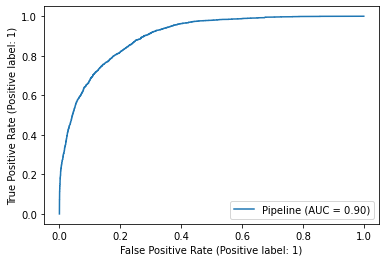

In [29]:
plot_roc_curve(estimator, x_test, y_test)

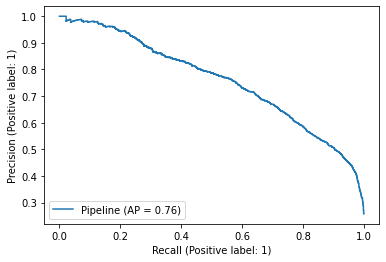

In [30]:
plot_precision_recall_curve(estimator, x_test, y_test)

## Hypermeter Tuning

In [31]:
logreg = LogisticRegression(solver = 'liblinear', C = 1)

estimator = Pipeline([
    ('transformer', transformer),
    ('model', logreg)
])

hyperparam_space = {
    'model__C': [100,10,1,0.1,0.001,0.0001],
    'model__solver': ['liblinear', 'newton-cg']
}

skfold = StratifiedKFold(n_splits=5)

grid_search = GridSearchCV(
    estimator,
    param_grid = hyperparam_space,
    cv = skfold,
    scoring = 'f1', 
    n_jobs = -1
)

In [32]:
grid_search.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('one '
                                                                         'hot '
                                                                         'encoder',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['relationship',
                                                                          'race',
                                                                          'sex']),
                                                                        ('binary '
                                                                         'encoder',
               

In [33]:
print('Skor', grid_search.best_score_)
print('Model', grid_search.best_params_)

Skor 0.6500973400331815
Model {'model__C': 10, 'model__solver': 'newton-cg'}


In [34]:
hasil_tuning = pd.DataFrame(grid_search.cv_results_)
hasil_tuning[(hasil_tuning['param_model__C'] == 1)&(hasil_tuning['param_model__solver'] == 'liblinear')]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,1.23354,0.055956,0.124875,0.015643,1,liblinear,"{'model__C': 1, 'model__solver': 'liblinear'}",0.637105,0.639713,0.635233,0.64369,0.653395,0.641827,0.006442,6


In [35]:
hasil_tuning[(hasil_tuning['param_model__C'] == 10)&(hasil_tuning['param_model__solver'] == 'newton-cg')]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,7.755316,0.601759,0.132737,0.029457,10,newton-cg,"{'model__C': 10, 'model__solver': 'newton-cg'}",0.644411,0.655,0.637487,0.655052,0.658537,0.650097,0.007889,1


## Comparasson before and after tuning

In [36]:

logreg = LogisticRegression(solver = 'liblinear')

estimator = Pipeline([
    ('transformer', transformer),
    ('model', logreg)
])

estimator.fit(x_train, y_train)
y_pred = estimator.predict(x_test)
print(classification_report(y_test, y_pred))
print(f1_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      7417
           1       0.75      0.58      0.65      2352

    accuracy                           0.85      9769
   macro avg       0.81      0.76      0.78      9769
weighted avg       0.85      0.85      0.85      9769

0.6543800861656294


In [37]:
estimator = grid_search.best_estimator_


estimator.fit(x_train, y_train)

y_pred = estimator.predict(x_test)
print(classification_report(y_test, y_pred))
print(f1_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      7417
           1       0.75      0.59      0.66      2352

    accuracy                           0.85      9769
   macro avg       0.81      0.77      0.78      9769
weighted avg       0.85      0.85      0.85      9769

0.661935178613674
